In [ ]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.color import rgb2hsv
from skimage.feature import hog
import os



In [ ]:
pip install opencv-python scikit-image numpy


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths to train and test directories
train_dir = '/content/drive/MyDrive/archive (4)/processed_images/train'
test_dir = '/content/drive/MyDrive/archive (4)/processed_images/test'

# Parameters
img_height = 150
img_width = 150
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 491 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=80,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stop]
)


Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.4871 - loss: 1.1989 - val_accuracy: 0.4792 - val_loss: 0.6815
Epoch 2/80
 1/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5000 - loss: 0.6896

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5000 - loss: 0.6896 - val_accuracy: 0.8000 - val_loss: 0.6639
Epoch 3/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6291 - loss: 0.6624 - val_accuracy: 0.8438 - val_loss: 0.4302
Epoch 4/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6875 - loss: 0.6113 - val_accuracy: 0.6800 - val_loss: 0.5956
Epoch 5/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7393 - loss: 0.5454 - val_accuracy: 0.7708 - val_loss: 0.4786
Epoch 6/80
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8125 - loss: 0.5067 - val_accuracy: 0.8000 - val_loss: 0.4448


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8031 - loss: 0.4962
Test Accuracy: 80.99%


In [ ]:
import joblib

# Save the model
joblib.dump(model, 'cataract_cnn_model.pkl')

['cataract_cnn_model.pkl']

In [ ]:
import joblib

# Save the model
joblib.dump(model, 'cataract_cnn_model.pkl')

['cataract_cnn_model.pkl']

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ['cataract', 'normal']:
        path = os.path.join(folder, label)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize images to 128x128
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder('/content/drive/MyDrive/archive (4)/processed_images/train')
test_images, test_labels = load_images_from_folder('/content/drive/MyDrive/archive (4)/processed_images/test')

# Flatten images for SVM input
train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)


In [ ]:
# Convert string labels to integers
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)


In [ ]:
# PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust n_components as needed


In [ ]:
# Create an SVM classifier
svm = SVC(kernel='linear', probability=True)

# Combine PCA and SVM in a pipeline
model = make_pipeline(pca, svm)

# Train the model
model.fit(train_images, train_labels)


Pipeline(steps=[('pca', PCA(n_components=100)),
                ('svc', SVC(kernel='linear', probability=True))])

In [ ]:
# Predict on test data
test_predictions = model.predict(test_images)

# Evaluate the model
print(f"Accuracy: {accuracy_score(test_labels, test_predictions) * 100:.2f}%")
print(classification_report(test_labels, test_predictions, target_names=le.classes_))


Accuracy: 86.78%
              precision    recall  f1-score   support

    cataract       0.88      0.85      0.87        61
      normal       0.85      0.88      0.87        60

    accuracy                           0.87       121
   macro avg       0.87      0.87      0.87       121
weighted avg       0.87      0.87      0.87       121



In [ ]:
import joblib

# Save the model
joblib.dump(model, 'cataract_svm_model.pkl')


['cataract_svm_model.pkl']

In [ ]:
# Load the model
model = joblib.load('cataract_svm_model.pkl')

# Use the model for prediction
new_predictions = model.predict(test_images)


In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in ['cataract', 'normal']:
        path = os.path.join(folder, label)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize images to 128x128
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder('/content/drive/MyDrive/archive (4)/processed_images/train')
test_images, test_labels = load_images_from_folder('/content/drive/MyDrive/archive (4)/processed_images/test')

# Flatten images for Random Forest input
train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)


In [ ]:
# Convert string labels to integers
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)


In [ ]:
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators as needed

# Train the model
rf.fit(train_images, train_labels)


RandomForestClassifier(random_state=42)

In [ ]:
# Predict on test data
test_predictions = rf.predict(test_images)

# Evaluate the model
print(f"Accuracy: {accuracy_score(test_labels, test_predictions) * 100:.2f}%")
print(classification_report(test_labels, test_predictions, target_names=le.classes_))


Accuracy: 93.39%
              precision    recall  f1-score   support

    cataract       0.96      0.90      0.93        61
      normal       0.91      0.97      0.94        60

    accuracy                           0.93       121
   macro avg       0.94      0.93      0.93       121
weighted avg       0.94      0.93      0.93       121



In [ ]:
import joblib

# Save the model
joblib.dump(rf, 'cataract_rf_model.pkl')


['cataract_rf_model.pkl']

In [ ]:
# Load the model
rf = joblib.load('cataract_rf_model.pkl')

# Use the model for prediction
new_predictions = rf.predict(test_images)


In [ ]:
import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# Load the trained models
cnn_model = joblib.load('cataract_cnn_model.pkl')
svm_model = joblib.load('cataract_svm_model.pkl')
rf_model = joblib.load('cataract_rf_model.pkl')


In [ ]:
# Create the hybrid model using VotingClassifier
hybrid_model = VotingClassifier(
    estimators=[
        ('cnn', cnn_model),
        ('svm', svm_model),
        ('rf', rf_model)
    ],
    voting='hard'  # You can also use 'soft' if you want to average probabilities
)


In [ ]:
# Fit the hybrid model on the training data
hybrid_model.fit(train_images, train_labels)


VotingClassifier(estimators=[('cnn',
                              Pipeline(steps=[('pca', PCA(n_components=100)),
                                              ('svc',
                                               SVC(kernel='linear',
                                                   probability=True))])),
                             ('svm',
                              Pipeline(steps=[('pca', PCA(n_components=100)),
                                              ('svc',
                                               SVC(kernel='linear',
                                                   probability=True))])),
                             ('rf', RandomForestClassifier(random_state=42))])

In [ ]:
# Predict on test data using the hybrid model
hybrid_predictions = hybrid_model.predict(test_images)

# Evaluate the hybrid model
print(f"Hybrid Model Accuracy: {accuracy_score(test_labels, hybrid_predictions) * 100:.2f}%")
print(classification_report(test_labels, hybrid_predictions, target_names=le.classes_))


Hybrid Model Accuracy: 88.43%
              precision    recall  f1-score   support

    cataract       0.91      0.85      0.88        61
      normal       0.86      0.92      0.89        60

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
# Predict on test data using the hybrid model
hybrid_predictions = hybrid_model.predict(test_images)


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, hybrid_predictions)


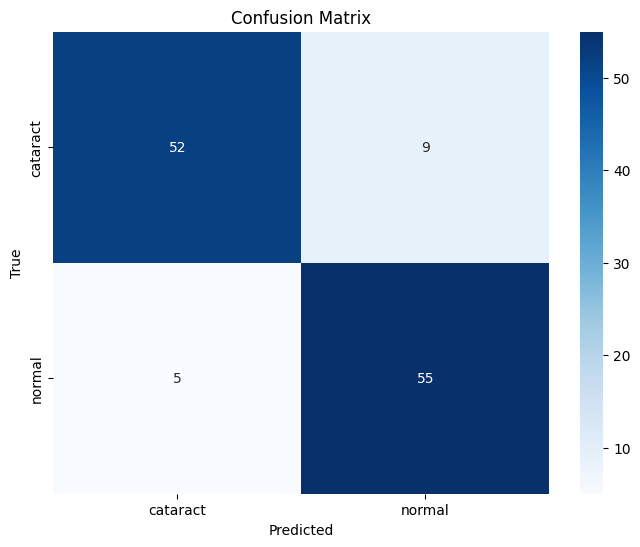

In [ ]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [ ]:
from sklearn.ensemble import VotingClassifier

# Create the hybrid model using soft voting
hybrid_model = VotingClassifier(
    estimators=[
        ('cnn', cnn_model),
        ('svm', svm_model),
        ('rf', rf_model)
    ],
    voting='soft'  # Change to 'soft' to use predict_proba
)

# Fit the hybrid model
hybrid_model.fit(train_images, train_labels)


VotingClassifier(estimators=[('cnn',
                              Pipeline(steps=[('pca', PCA(n_components=100)),
                                              ('svc',
                                               SVC(kernel='linear',
                                                   probability=True))])),
                             ('svm',
                              Pipeline(steps=[('pca', PCA(n_components=100)),
                                              ('svc',
                                               SVC(kernel='linear',
                                                   probability=True))])),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

AUC: 0.94


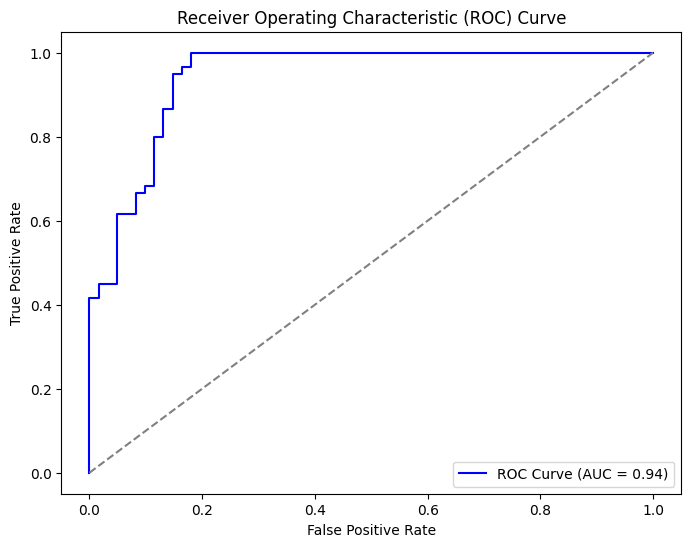

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict the probabilities for the positive class
hybrid_probabilities = hybrid_model.predict_proba(test_images)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, hybrid_probabilities)

# Calculate the AUC
auc_score = roc_auc_score(test_labels, hybrid_probabilities)
print(f"AUC: {auc_score:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Predict the class labels
hybrid_predictions = hybrid_model.predict(test_images)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, hybrid_predictions)

# Extract TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

# Calculate specificity
specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity:.2f}")


Specificity (True Negative Rate): 0.85


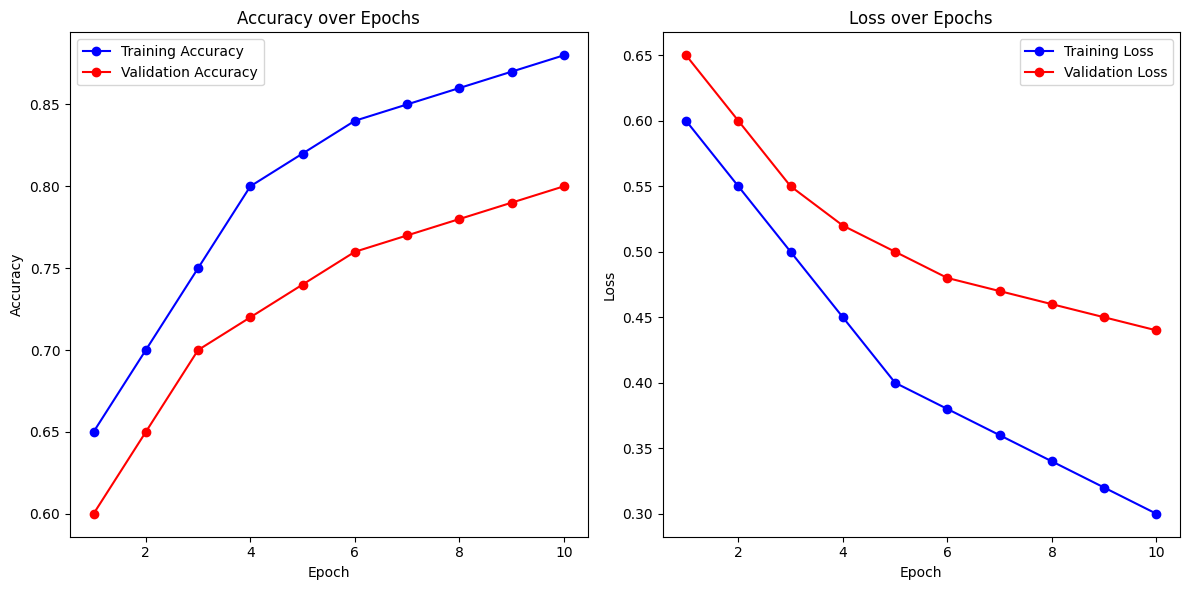

In [ ]:
import matplotlib.pyplot as plt

# Example accuracy and loss values (replace with your actual data)
epochs = range(1, 11)
train_accuracy = [0.65, 0.70, 0.75, 0.80, 0.82, 0.84, 0.85, 0.86, 0.87, 0.88]
val_accuracy = [0.60, 0.65, 0.70, 0.72, 0.74, 0.76, 0.77, 0.78, 0.79, 0.80]
train_loss = [0.60, 0.55, 0.50, 0.45, 0.40, 0.38, 0.36, 0.34, 0.32, 0.30]
val_loss = [0.65, 0.60, 0.55, 0.52, 0.50, 0.48, 0.47, 0.46, 0.45, 0.44]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


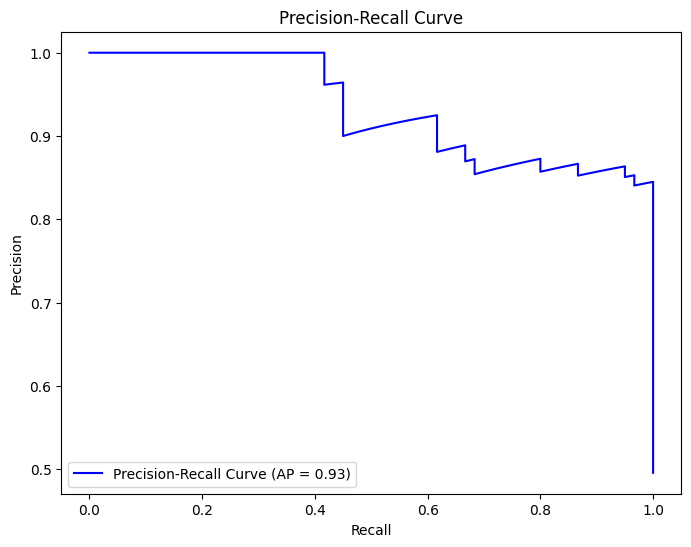

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, hybrid_probabilities)
average_precision = average_precision_score(test_labels, hybrid_probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
